# 0. Load parameters


In [1]:
# | tags: [parameters]
subject = "101"

In [2]:
# | tags: [parameters]
# Injected Parameters
subject = 106

In [3]:
from datetime import datetime


def print_date_time():
    now = datetime.now()
    # Convert the date and time to a string
    now_str = now.strftime("%Y-%m-%d %H:%M:%S")

    # Print the date and time
    print(now_str)


print_date_time()

2024-03-19 02:36:24


This file contains preprocessing files after downsampling them.


In [4]:
import mne
import toml
from pathlib import Path
import matplotlib.pyplot as plt


from eeglabio.utils import export_mne_raw

from meegkit.detrend import detrend
from meegkit import dss
from pyprep.find_noisy_channels import NoisyChannels


# This part could be replaced by read MFF files (set files are just downsampled MFF files saved to the local laptop drive)
def load_data(subject: str) -> mne.io.Raw:
    fname_path = f"{project_path}/data/raw/BIDS/sub-{
        subject}/ses-01/eeg/sub-{subject}_ses-01_task-rest_eeg.set"
    raw = mne.io.read_raw_eeglab(fname_path, preload=True)
    ch_name_type = dict(zip(raw.ch_names, raw.get_channel_types()))
    ch_name_ecg = [name for name in raw.ch_names if name in "ECG"]
    dict_ecg = {sub[0]: "ecg" for sub in (ele.split() for ele in ch_name_ecg)}
    raw.set_channel_types(dict_ecg)
    montage = mne.channels.make_standard_montage("GSN-HydroCel-257")
    raw.set_montage(montage, match_alias={"VREF": "Cz"})
    raw.info["bads"] = ["VREF"]
    return raw


def detrending(raw, order=10):
    # detrending
    data = raw.get_data().T  # Convert mne data to numpy darray
    # data, _, _ = detrend(data, order=1)
    data, _, _ = detrend(data, order=order)
    detrended_raw = mne.io.RawArray(
        data.T, raw.info
    )  # Convert output to mne RawArray again
    return detrended_raw


def apply_pyprep(raw, save_figs=True):
    nd = NoisyChannels(raw, random_state=1337)
    # nd.find_bad_by_correlation(
    #    correlation_secs=1.0, correlation_threshold=0.4, frac_bad=0.01
    # )
    # nd.find_bad_by_deviation(deviation_threshold=5.0)
    nd.find_all_bads(ransac=True, channel_wise=True, max_chunk_size=None)
    # find bad by RANSAC is conservative estimate
    # nd.find_bad_by_ransac(channel_wise=True)
    # print("bad by ransc", nd.bad_by_ransac)
    # print("bad by deviation", nd.bad_by_deviation)
    # print("bad by correlation", nd.bad_by_correlation)
    display
    ("bad all", nd.get_bads(verbose=True))

    clean_raw = raw.copy()
    clean_raw.info["bads"].extend(nd.bad_by_ransac)
    clean_raw.info["bads"].extend(nd.bad_by_deviation)
    clean_raw.info["bads"].extend(nd.get_bads(verbose=False))

    sensor_plot = clean_raw.plot_sensors(show_names=True)
    if save_figs:
        sensor_plot.savefig(
            f"{figure_path}/sub-{subject}_bad_sensors.png", dpi=300, bbox_inches="tight"
        )
    return clean_raw


def apply_projection(raw):
    raw_clean = raw.copy()
    raw_clean.interpolate_bads()
    raw_clean.set_eeg_reference("average", projection=True)  # compute the reference
    raw_ref = raw.copy().add_proj(raw_clean.info["projs"][0])
    return raw_ref.apply_proj()  # apply the reference


def create_epochs(raw):
    length = 5
    events = mne.make_fixed_length_events(
        raw=raw,
        start=0,
        stop=None,
        duration=length,
        overlap=0,
        first_samp=False,
    )

    # Create  Epochs object
    epochs = mne.Epochs(
        raw=raw,
        events=events,
        tmin=0,
        tmax=length,
        detrend=1,  # from 0 to 1
        baseline=None,
        preload=True,
    )
    return epochs

In [5]:
mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = toml.load("../../.env.toml")
project_path = config["project"]["path"]

preproc_path = f"{
    project_path}/data/preproc/sub-{subject}/raw/"
figure_path = f"{project_path}/analysis/sub-{subject}/figures"


Path(preproc_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)

Using matplotlib as 2D backend.


# 1. Preprocess raw data


Filtering raw data in 1 contiguous segment


Setting up band-pass filter from 1 - 1e+02 Hz


FIR filter parameters


---------------------


Designing a one-pass, zero-phase, non-causal bandpass filter:


- Windowed frequency-domain design (firwin2) method


- Hamming window


- Lower passband edge: 1.00


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)


- Upper passband edge: 100.00 Hz


- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)


- Filter length: 3301 samples (6.602 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s


[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.4s


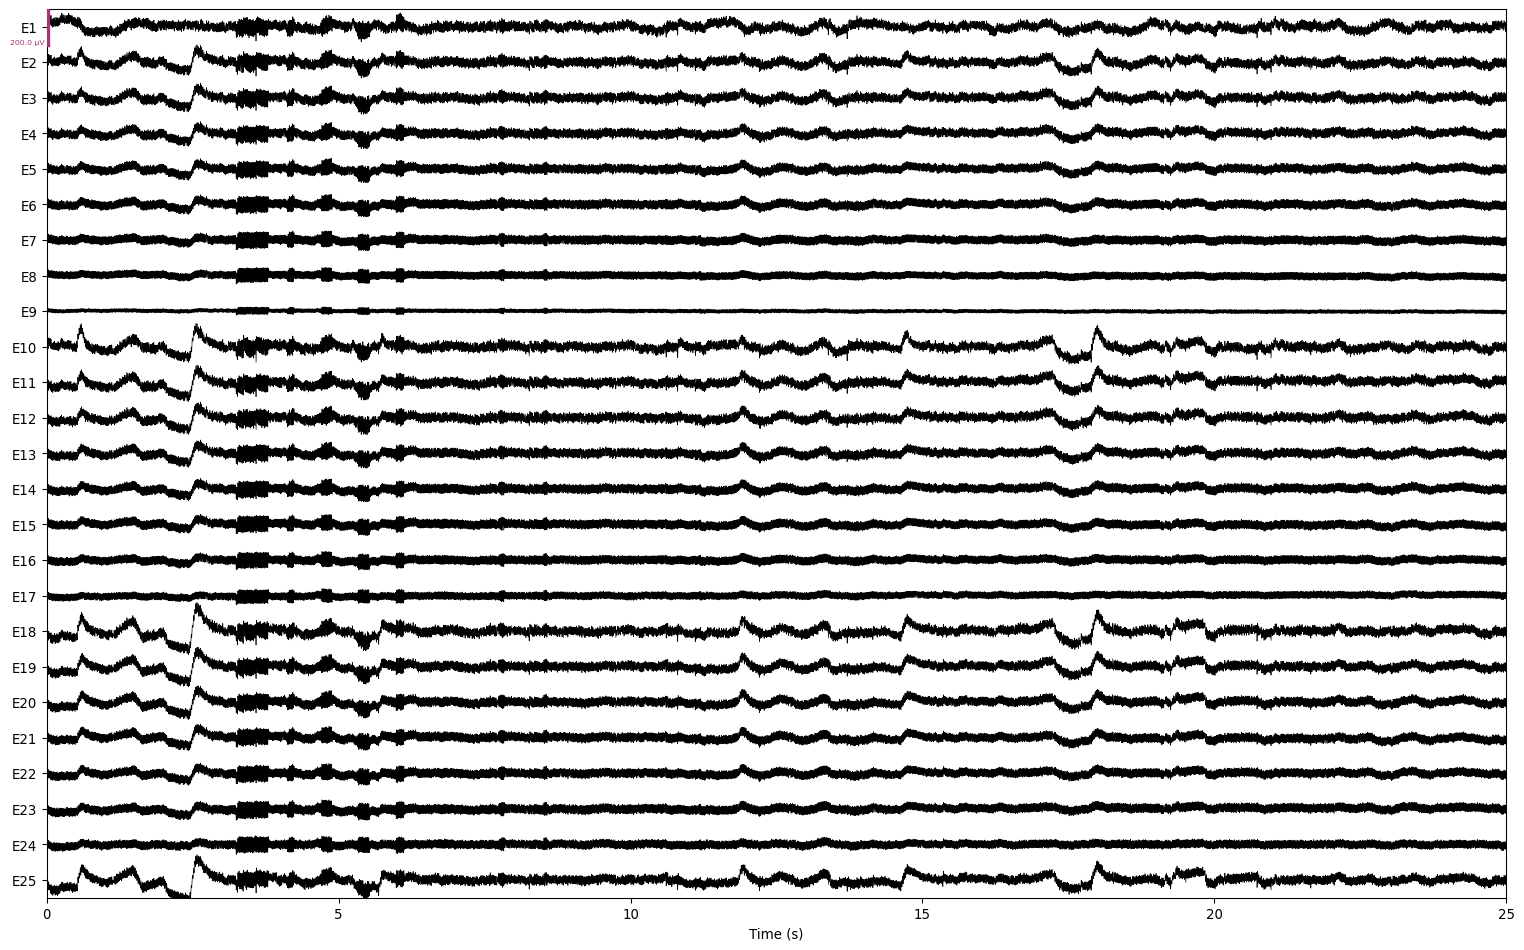

Effective window size : 4.096 (s)


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_27154/3379535649.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,260 points
Good channels,"256 EEG, 1 ECG"
Bad channels,VREF
EOG channels,Not available
ECG channels,ECG
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,100.00 Hz


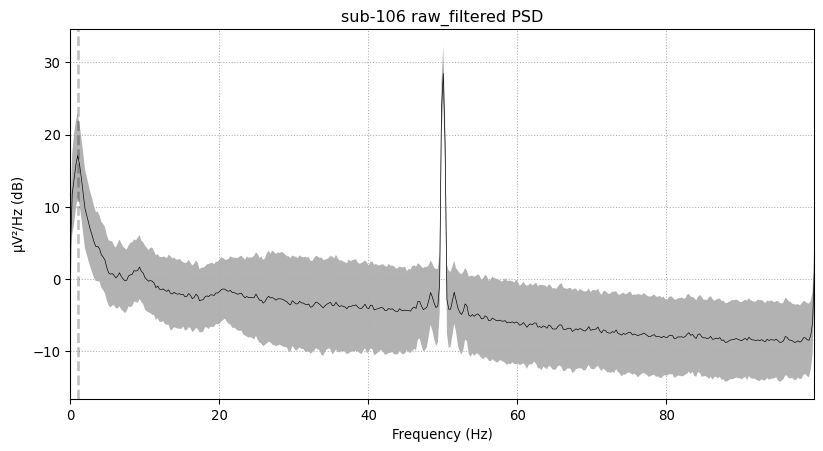

In [6]:
fline = 50
h_freq = 100


def zapline_clean(raw, fline, method="line", iter_param=None):
    data = raw.get_data().T  # Convert mne data to numpy darray
    sfreq = raw.info["sfreq"]  # Extract the sampling freq
    # Apply MEEGkit toolbox function

    if method == "iter":
        temp_data, _ = dss.dss_line_iter(data, fline, sfreq, **iter_param)
        out, _ = dss.dss_line_iter(temp_data, fline, sfreq, **iter_param)
    elif method == "line":
        out, _ = dss.dss_line(data, fline, sfreq, nremove=15)

    cleaned_raw = mne.io.RawArray(
        out.T, raw.info
    )  # Convert output to mne RawArray again

    return cleaned_raw


def plot_step(temp, stage="raw", duration=50.0, n_channels=50, fmax=100.0):
    raw_plot = mne.viz.plot_raw(
        temp.copy(),
        duration=duration,
        scalings=dict(eeg=1e-4),
        n_channels=n_channels,
        show_scrollbars=False,
        title=f"sub-{subject} {stage}",
    )
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    raw_plot.savefig(
        f"{figure_path}/sub-{subject}_{stage}.png", dpi=300, bbox_inches="tight"
    )
    plt.close()

    # Plot is saved to monitor the quality of the data
    fig, ax = plt.subplots(figsize=(10, 5))
    raw_psd = temp.compute_psd(
        fmax=fmax, method="welch", picks="eeg", exclude="bads"
    ).plot(average=True, picks="eeg", exclude="bads", show=False, axes=ax)
    ax.set_title(f"sub-{subject} {stage} PSD")
    raw_psd.savefig(
        f"{figure_path}/sub-{subject}_{stage}-psd.png", dpi=300, bbox_inches="tight"
    )
    fig.show()


filter_params = {
    "l_freq": 1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
}


# .notch_filter(freqs=50)  # removedrifts
#
raw = load_data(subject)
raw.info["bads"] = ["VREF"]

raw_filtered = (
    raw.copy()
    .crop(tmin=5, tmax=300, include_tmax=True)
    .resample(500.0)
    .filter(**filter_params)
)
plot_step(raw_filtered, stage="raw_filtered", duration=25.0, n_channels=25, fmax=h_freq)


raw_filtered.info

Power of components removed by DSS: 0.18


Iteration 0 score: 1.4287172630731832e-11


Power of components removed by DSS: 0.05


Iteration 1 score: 1.9289688205959504e-12


Power of components removed by DSS: 0.00


Iteration 2 score: 1.4379491446224022e-12


Power of components removed by DSS: 0.00


Iteration 3 score: 4.916457736918909e-13


Power of components removed by DSS: 0.00


Iteration 4 score: 8.771157046189205e-14


Power of components removed by DSS: 0.00


Iteration 5 score: -2.917593562308208e-14


Power of components removed by DSS: 0.00


Iteration 0 score: 3.934049858373195e-14


Power of components removed by DSS: 0.00


Iteration 1 score: 3.5863359491245805e-14


Power of components removed by DSS: 0.00


Iteration 2 score: 2.4937697201147152e-14


Power of components removed by DSS: 0.00


Iteration 3 score: 1.0557324270442389e-14


Power of components removed by DSS: 0.00


Iteration 4 score: 5.439972940041778e-15


Power of components removed by DSS: 0.00


Iteration 5 score: 4.4723649099894536e-15


Power of components removed by DSS: 0.00


Iteration 6 score: 3.0451124855609707e-15


Power of components removed by DSS: 0.00


Iteration 7 score: 2.563534974144267e-15


Power of components removed by DSS: 0.00


Iteration 8 score: 1.6655958588310082e-15


Power of components removed by DSS: 0.00


Iteration 9 score: 1.0407867308880257e-15


Power of components removed by DSS: 0.00


Iteration 10 score: 3.2056531815568167e-16


Power of components removed by DSS: 0.00


Iteration 11 score: -3.7770353801135182e-16
Creating RawArray with float64 data, n_channels=258, n_times=147500


    Range : 0 ... 147499 =      0.000 ...   294.998 secs


Ready.


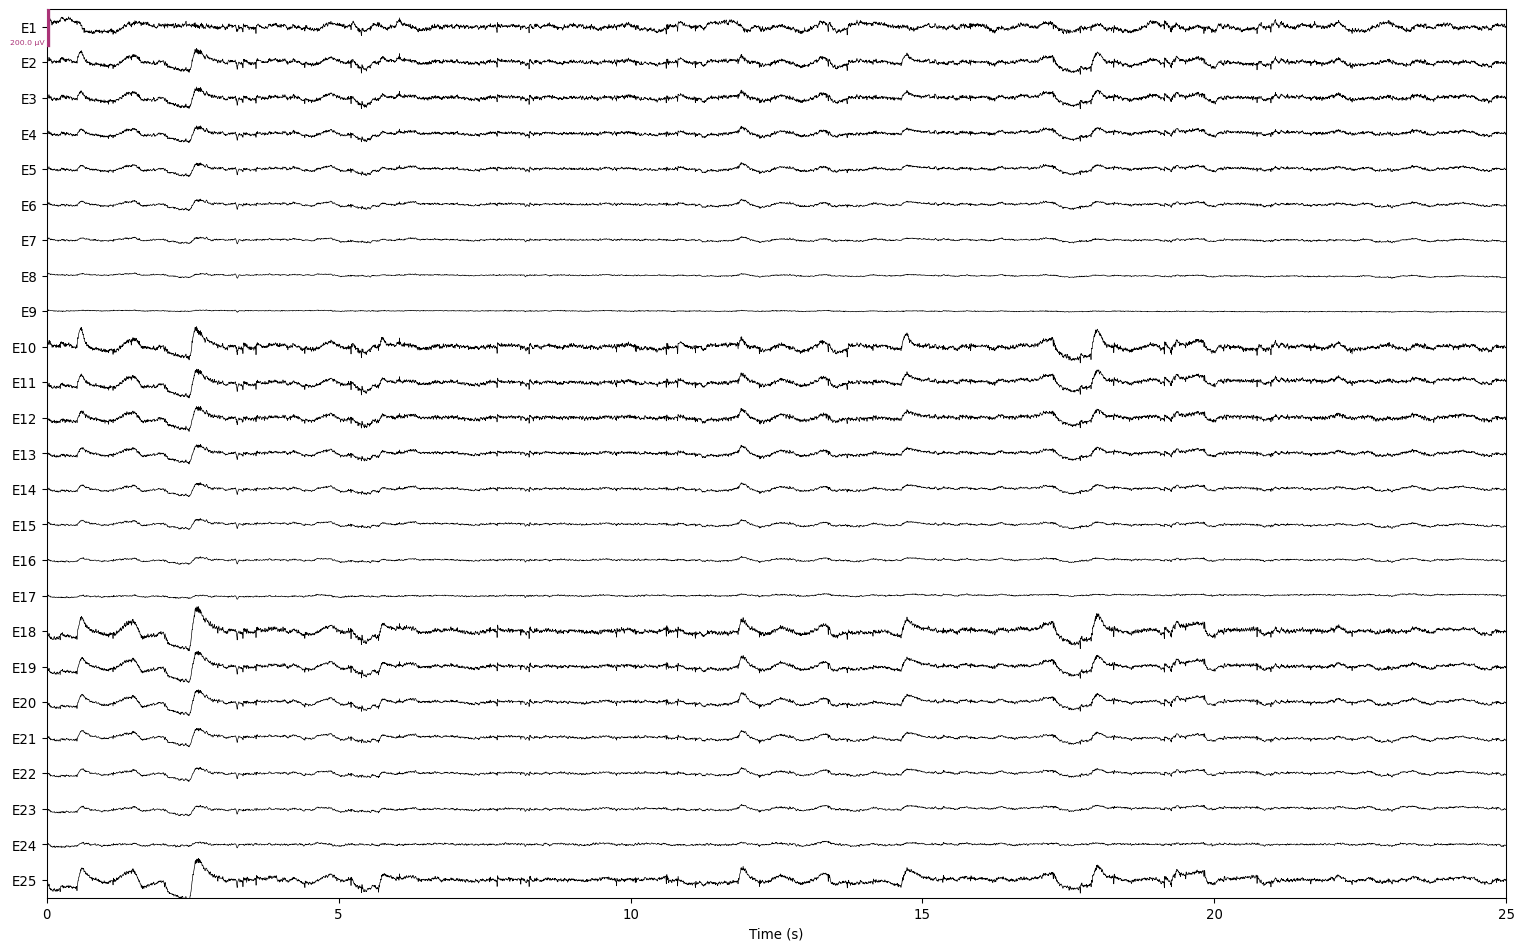

Effective window size : 4.096 (s)


/var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_27154/3379535649.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


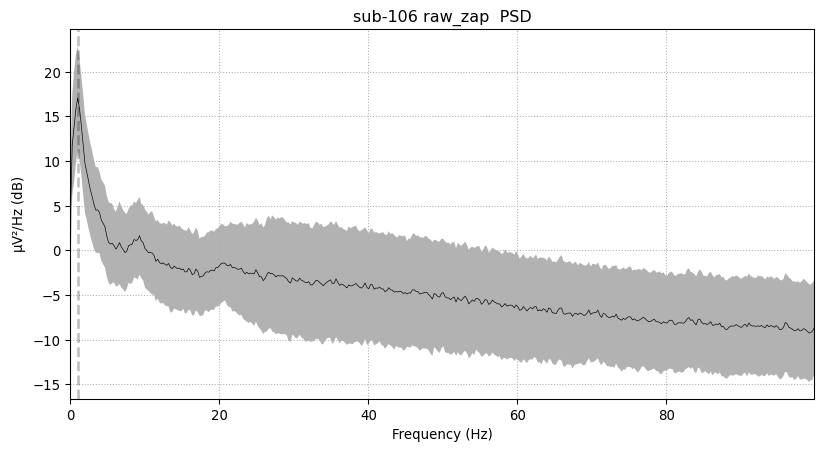

In [7]:
iter_param = {
    "nfft": 256,
    "n_iter_max": 200,
    "win_sz": 10,
    "spot_sz": 5,
}
raw_zap = zapline_clean(raw_filtered, fline, method="iter", iter_param=iter_param)
plot_step(raw_zap, stage="raw_zap ", duration=25.0, n_channels=25, fmax=h_freq)

In [44]:
# raw_clean = apply_pyprep(raw_zap)
# raw_clean.info
# raw_clean.save(f"{preproc_path}/sub-{subject}_filtered_zap_eeg.fif", overwrite=True)

from autoreject import Ransac  # noqa


def get_bad_channels(raw):
    # plot the data
    clean_raw_downsampled = raw.copy().resample(125, npad="auto")
    epochs = create_epochs(clean_raw_downsampled)
    # plot_epochs(epochs, stage="epochs", n_epochs=10, n_channels=25)
    ransac = Ransac(verbose=False, n_jobs=-1)
    _ = ransac.fit_transform(epochs)
    print("\n".join(ransac.bad_chs_))

    return [x for x in ransac.bad_chs_]


bad_channels_by_ransac = get_bad_channels(raw_zap)
raw_zap.info["bads"].extend(bad_channels_by_ransac)
raw_zap.info
raw_zap.save(f"{preproc_path}/sub-{subject}_filtered_zap_eeg.fif", overwrite=True)

Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 59 events and 626 original time points ...
1 bad epochs dropped


python(29042) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29043) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29044) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29045) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29046) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29047) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29048) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29049) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(29051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.5 mm
Computing interpolation matrix from 252 sensor positions
Interpolating 5 sensors
E90
E91
E208
E216
E241
Writing /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-104/raw/sub-104_filtered_zap_eeg.fif
Closing /Users/daniel/PhD/Projects/psd-path/data/preproc/sub-104/raw/sub-104_filtered_zap_eeg.fif
[done]


In [ ]:
print(f"{subject} -  removed {bad_channels_by_ransa} channels")
print_date_time()